# Machine Intelligence II - Team MensaNord
## Sheet 11

- Nikolai Zaki
- Alexander Moore
- Johannes Rieke
- Georg Hoelger
- Oliver Atanaszov

In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#import seaborn as sns
#sns.set_style('whitegrid')

## Exercise 2


### 1.1 Create dataset

In [2]:
M = 2
w1, w2 = [2,2], [1,1]  # means
sigma2 = 0.2  # standard deviations
N = 100
P1, P2 = 2/3, 1/3

def create_data(sigma1=0.7):
    X = np.zeros((N, 2))
    which_gaussian = np.zeros(N)

    for n in range(N):
        if np.random.rand() < P1:  # sample from first Gaussian
            X[n] = np.random.multivariate_normal(w1, np.eye(len(w1)) * sigma1**2)
            which_gaussian[n] = 0
        else:  # sample from second Gaussian
            X[n] = np.random.multivariate_normal(w2, np.eye(len(w2)) * sigma2**2)
            which_gaussian[n] = 1
            
    return X, which_gaussian

sigma1 = 0.7
X, which_gaussian = create_data(sigma1)

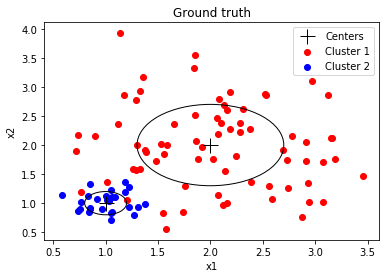

In [3]:
def plot_data(X, which_gaussian, centers, stds):
    plt.scatter(*X[which_gaussian == 0].T, c='r', label='Cluster 1')
    plt.scatter(*X[which_gaussian == 1].T, c='b', label='Cluster 2')
    plt.plot(centers[0][0], centers[0][1], 'k+', markersize=15, label='Centers')
    plt.plot(centers[1][0], centers[1][1], 'k+', markersize=15)
    plt.gca().add_artist(plt.Circle(centers[0], stds[0], ec='k', fc='none'))
    plt.gca().add_artist(plt.Circle(centers[1], stds[1], ec='k', fc='none'))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    
plot_data(X, which_gaussian, [w1, w2], [sigma1, sigma2])
plt.title('Ground truth')

### 1.2 Run Expectation-Maximization algorithm

See slide 18 of the lecture for an outline of the algorithm.

In [4]:
from scipy.stats import multivariate_normal

In [5]:
def variance(X):
    """Calculate a single variance value for the vectors in X."""
    mu = X.mean(axis=0)
    return np.mean([np.linalg.norm(x - mu)**2 for x in X])

def run_expectation_maximization(X, w=None, sigma_squared=None, verbose=False):
    # Initialization.
    P_prior = np.ones(2) * 1 / M
    P_likelihood = np.zeros((N, M))
    P_posterior = np.zeros((M, N))
    
    mu = X.mean(axis=0)  # mean of the original data
    var = variance(X)  # variance of the original data

    if w is None:
        w = np.array([mu + np.random.rand(M) - 0.5, mu + np.random.rand(M) - 0.5])

    if sigma_squared is None:
        sigma_squared = np.array([var + np.random.rand() - 0.5,var + np.random.rand() - 0.5])
        #sigma_squared = np.array([var, var])

    if verbose:
        print('Initial centers:', w)
        print('Initial variances:', sigma_squared)
        print()
        print()


    theta = 0.001
    distance = np.inf
    step = 0


    # Optimization loop.
    while distance > theta:
    #for i in range(1):
        step += 1
        if verbose:
            print('Step', step)
            print('-'*50)

        # Store old parameter values to calculate distance later on.
        w_old = w.copy()
        sigma_squared_old = sigma_squared.copy()
        P_prior_old = P_prior.copy()

        if verbose:
            print('Distances of X[0] to proposed centers:', np.linalg.norm(X[0] - w[0]), np.linalg.norm(X[0] - w[1]))

        # E-Step: Calculate likelihood for each data point.
        for (alpha, q), _ in np.ndenumerate(P_likelihood):
            P_likelihood[alpha, q] = multivariate_normal.pdf(X[alpha], w[q], sigma_squared[q])

        if verbose:
            print('Likelihoods of X[0]:', P_likelihood[0])

        # E-Step: Calculate assignment probabilities (posterior) for each data point.
        for (q, alpha), _ in np.ndenumerate(P_posterior):
            P_posterior[q, alpha] = (P_likelihood[alpha, q] * P_prior[q]) / np.sum([P_likelihood[alpha, r] * P_prior[r] for r in range(M)])

        if verbose:
            print('Assignment probabilities of X[0]:', P_posterior[:, 0])
            print()

        distance = 0
        # M-Step: Calculate new parameter values.
        for q in range(M):
            w[q] = np.sum([P_posterior[q, alpha] * X[alpha] for alpha in range(N)], axis=0) / np.sum(P_posterior[q])
            #print(np.sum([P_posterior[q, alpha] * X[alpha] for alpha in range(N)], axis=0))
            #print(np.sum(P_posterior[q]))
            w_distance = np.linalg.norm(w[q] - w_old[q])
            if verbose:
                print('Distance of centers:', w_distance)
            distance = max(distance, w_distance)

            sigma_squared[q] = 1 / M * np.sum([np.linalg.norm(X[alpha] - w_old[q])**2 * P_posterior[q, alpha] for alpha in range(N)]) / np.sum(P_posterior[q])
            sigma_squared_distance = np.abs(sigma_squared[q] - sigma_squared_old[q])
            if verbose:
                print('Distance of variances:', sigma_squared_distance)
            distance = max(distance, sigma_squared_distance)

            P_prior[q] = np.mean(P_posterior[q])
            P_prior_distance = np.abs(P_prior[q] - P_prior_old[q])
            if verbose:
                print('Distance of priors:', P_prior_distance)
            distance = max(distance, P_prior_distance)


        if verbose:
            print('Maximum distance:', distance)

            print()
            print('New centers:', w)
            print('New variances:', sigma_squared)
            print('New priors:', P_prior)

            print('='*50)
            print()

    which_gaussian_EM = P_posterior.argmax(axis=0)
    
    return which_gaussian_EM, w, np.sqrt(sigma_squared), step

which_gaussian_em, cluster_centers_em, cluster_stds_em, num_steps_em = run_expectation_maximization(X, verbose=True)

Initial centers: [[ 1.2938712   2.13233145]
 [ 1.73146591  1.43440641]]
Initial variances: [ 1.535102    0.72676323]


Step 1
--------------------------------------------------
Distances of X[0] to proposed centers: 1.28249075345 0.936357844332
Likelihoods of X[0]: [ 0.06067654  0.11980118]
Assignment probabilities of X[0]: [ 0.33619963  0.66380037]

Distance of centers: 0.50780022779
Distance of variances: 0.776594791989
Distance of priors: 0.0997384021048
Distance of centers: 0.140708188768
Distance of variances: 0.229453957597
Distance of priors: 0.0997384021048
Maximum distance: 0.776594791989

New centers: [[ 1.76568541  1.94457517]
 [ 1.75141172  1.57369373]]
New variances: [ 0.75850721  0.49730927]
New priors: [ 0.4002616  0.5997384]

Step 2
--------------------------------------------------
Distances of X[0] to proposed centers: 1.32061724655 1.0383404055
Likelihoods of X[0]: [ 0.06646231  0.10824933]
Assignment probabilities of X[0]: [ 0.29066068  0.70933932]

Distance of cent

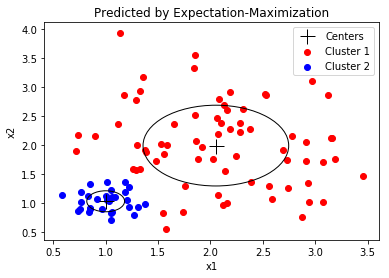

In [6]:
plot_data(X, which_gaussian_em, cluster_centers_em, cluster_stds_em)
plt.title('Predicted by Expectation-Maximization')

### 1.3 Run K-means algorithm

For simplicity, we use the sklearn version of K-means here. The detailed algorithm was already implemented in a previous exercise. 

In [7]:
from sklearn.cluster import KMeans

In [8]:
def run_k_means(X):
    km = KMeans(2)
    km.fit(X)
    which_gaussian_km = km.predict(X)
    cluster_stds = np.array([np.sqrt(variance(X[which_gaussian_km == 0])), np.sqrt(variance(X[which_gaussian_km == 1]))])
    return which_gaussian_km, km.cluster_centers_, cluster_stds

which_gaussian_km, cluster_centers_km, cluster_stds_km = run_k_means(X)

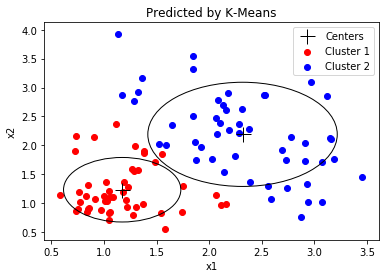

In [9]:
plot_data(X, which_gaussian_km, cluster_centers_km, cluster_stds_km)
plt.title('Predicted by K-Means')

K-means clusters the data point by establishing a straight separation line. This cannot fully capture the nature of the data, e.g. the points around the lower left Gaussian, which actually belong to the upper right Gaussian.

### 1.4 Initialize EM algorithm with cluster parameters from K-Means

In [10]:
_, _, _, num_steps_em_km = run_expectation_maximization(X, cluster_centers_km, cluster_stds_km**2)

In [11]:
print('Took', num_steps_em, 'steps with random initalization')
print('Took', num_steps_em_km, 'steps with initialization from K-means')

Took 22 steps with random initalization
Took 14 steps with initialization from K-means


### 1.5 Repeat analysis for different $\sigma_1$ values

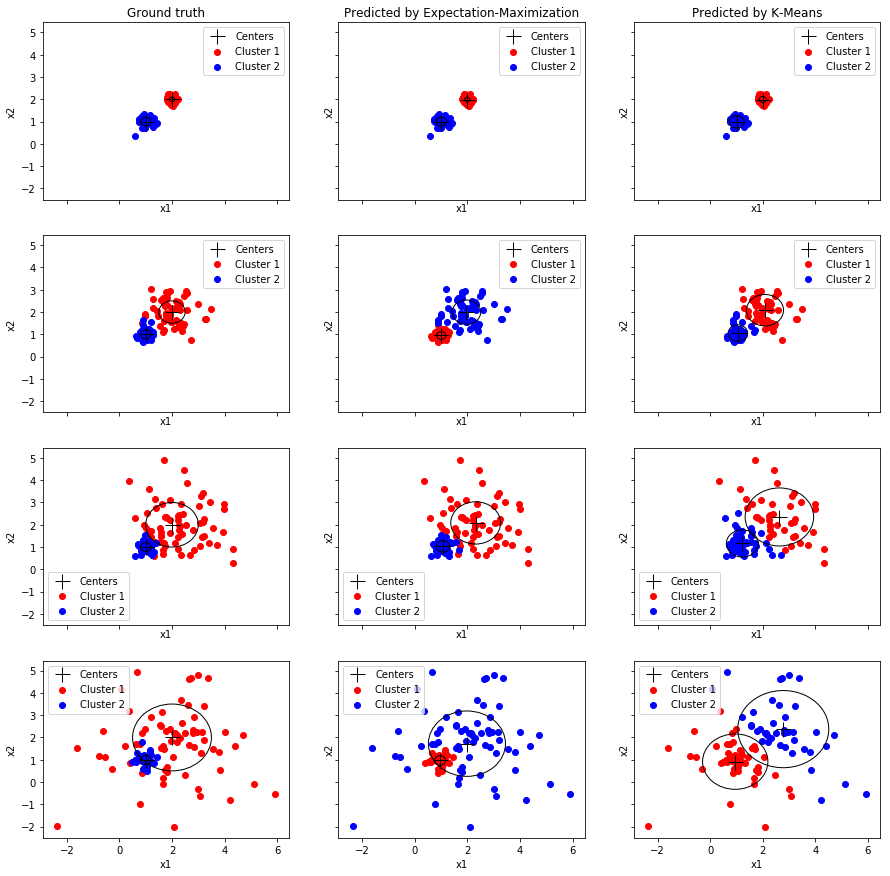

In [12]:
sigma1s = [0.1, 0.5, 1, 1.5]
fig, axes = plt.subplots(len(sigma1s), 3, figsize=(15, 15), sharex=True, sharey=True)

for i, (sigma1, horizontal_axes) in enumerate(zip(sigma1s, axes)):
    X, which_gaussian = create_data(sigma1)
    
    plt.sca(horizontal_axes[0])
    plot_data(X, which_gaussian, [w1, w2], [sigma1, sigma2])
    if i == 0:
        plt.title('Ground truth')
        
    which_gaussian_em, cluster_centers_em, cluster_stds_em, num_steps_em = run_expectation_maximization(X)
    plt.sca(horizontal_axes[1])
    plot_data(X, which_gaussian_em, cluster_centers_em, cluster_stds_em)
    if i == 0:
        plt.title('Predicted by Expectation-Maximization')
        
    which_gaussian_km, cluster_centers_km, cluster_stds_km = run_k_means(X)
    plt.sca(horizontal_axes[2])
    plot_data(X, which_gaussian_km, cluster_centers_km, cluster_stds_km)
    if i == 0:
        plt.title('Predicted by K-Means')

Each row corresponds to increasing $\sigma_1$ (the values are 0.1, 0.5, 1, 1.5).

K-means and Expectation-Maximization show similar results for small $\sigma_1$, i.e. if the clusters are clearly separated. With increasing $\sigma_1$, the Gaussians overlap more and more, and K-means fails to cluster them correctly.